In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read data
housing = pd.read_csv('../data/housing.csv')
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# **1. Add combine attribute**


In [3]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / \
    housing['total_rooms']
housing['population_per_household'] = housing['population'] / \
    housing['households']
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20640 non-null  float64
 1   latitude                  20640 non-null  float64
 2   housing_median_age        20640 non-null  float64
 3   total_rooms               20640 non-null  float64
 4   total_bedrooms            20433 non-null  float64
 5   population                20640 non-null  float64
 6   households                20640 non-null  float64
 7   median_income             20640 non-null  float64
 8   median_house_value        20640 non-null  float64
 9   ocean_proximity           20640 non-null  object 
 10  rooms_per_household       20640 non-null  float64
 11  bedrooms_per_room         20433 non-null  float64
 12  population_per_household  20640 non-null  float64
dtypes: float64(12), object(1)
memory usage: 2.0+ MB


In [4]:
numberics_columns = housing.select_dtypes("float64").columns
# delete the target column
numberics_columns = numberics_columns.drop("median_house_value")
category_columns = housing.select_dtypes("object").columns


# **2. Split data into train and test**


In [5]:
# import train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(housing.drop(
    "median_house_value", axis=1), housing["median_house_value"], test_size=0.2, random_state=42, stratify=housing["ocean_proximity"])

# **2. Construct a pipeline for preprocessing**


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


In [7]:
numberics_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())
])


In [8]:
category_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder())
])


In [9]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('numberics', numberics_pipeline, numberics_columns),
    ('category', category_pipeline, category_columns)
])

In [10]:
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)


# **3. Select and train a model**


In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)
lin_housing_prediction = lin_reg.predict(X_test_prepared)
lin_mse = mean_squared_error(y_test, lin_housing_prediction)
lin_rmse = np.sqrt(lin_mse)
lin_rmse


68276.29169831591

In [12]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_prepared, y_train)
tree_housing_prediction = tree_reg.predict(X_test_prepared)
tree_mse = mean_squared_error(y_test, tree_housing_prediction)
tree_rmse = np.sqrt(tree_mse)
tree_rmse


70229.00309502773

In [13]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_prepared, y_train)
forest_housing_prediction = forest_reg.predict(X_test_prepared)
forest_mse = mean_squared_error(y_test, forest_housing_prediction)
forest_rmse = np.sqrt(forest_mse)
forest_rmse


49313.62990194738

## **Test with Cross Validation**


In [14]:
from sklearn.model_selection import cross_val_score


def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [15]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(
    lin_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-lin_scores)
display_scores(tree_rmse_scores)

Scores: [69232.01794141 66699.04470534 68754.01032857 74238.17709526
 65317.14490738 65312.26557879 67154.71305157 69638.68350529
 69902.36277942 64742.31046289]
Mean: 68099.07303559133
Standard deviation: 2732.188316307572


In [16]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(
    tree_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [70679.81297302 74052.49650852 67051.00117621 69682.40605892
 70089.38972017 70083.34815136 68259.11333592 68684.07444983
 72196.65961721 73363.42296485]
Mean: 70414.1724956026
Standard deviation: 2118.5409230032483


In [17]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(
    forest_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-forest_scores)
display_scores(tree_rmse_scores)

Scores: [49692.44723929 50689.83280633 49958.66134923 49816.91774042
 47803.34239788 47479.81907478 48984.79572745 51819.18560222
 51835.23372837 49527.97346145]
Mean: 49760.820912742216
Standard deviation: 1383.517402103407


# **4. Fine-tune your model**


**Grid Search**


In [18]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train_prepared, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [19]:
grid_search.best_estimator_


RandomForestRegressor(max_features=8, n_estimators=30)

**Randomized Search**


In [20]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
randomized_search = RandomizedSearchCV(
    forest_reg, param_grid, cv=5, n_iter=10, scoring='neg_mean_squared_error', return_train_score=True)

randomized_search.fit(X_train_prepared, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions=[{'max_features': [2, 4, 6, 8],
                                         'n_estimators': [3, 10, 30]},
                                        {'bootstrap': [False],
                                         'max_features': [2, 3, 4],
                                         'n_estimators': [3, 10]}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [21]:
randomized_search.best_estimator_


RandomForestRegressor(max_features=8, n_estimators=30)

**Analyze the best models and their errors**


In [22]:
# print the importance scores next to their corresponding attribute names
cat_one_hot_attribs = list(preprocessor.named_transformers_[
                           "category"].named_steps["one_hot_encoder"].categories_[0])

attributes = numberics_columns.tolist() + cat_one_hot_attribs

In [23]:
print("GridSearchCV best estimator feature importance:")
print(sorted(zip(grid_search.best_estimator_.feature_importances_, attributes), reverse=True))


GridSearchCV best estimator feature importance:
[(0.3879435002333799, 'median_income'), (0.15417304134660087, 'INLAND'), (0.1140562935160183, 'population_per_household'), (0.06843167888393972, 'latitude'), (0.0651714257231372, 'longitude'), (0.0507378720518867, 'rooms_per_household'), (0.049030152116872214, 'bedrooms_per_room'), (0.041506788289223176, 'housing_median_age'), (0.015324469139282409, 'population'), (0.015094987522139076, 'total_rooms'), (0.01374852968570115, 'total_bedrooms'), (0.013461081991039486, 'households'), (0.005073569995209869, '<1H OCEAN'), (0.0038123960115523546, 'NEAR OCEAN'), (0.002114412917467163, 'NEAR BAY'), (0.0003198005765505391, 'ISLAND')]


In [24]:
print("RandomizedSearchCV best estimator feature importance:")
print(sorted(zip(randomized_search.best_estimator_.feature_importances_,
      attributes), reverse=True))

RandomizedSearchCV best estimator feature importance:
[(0.3761808199252091, 'median_income'), (0.15507842503329392, 'INLAND'), (0.10951504796873951, 'population_per_household'), (0.07145455610570134, 'longitude'), (0.06465492095817228, 'latitude'), (0.06435682151934567, 'bedrooms_per_room'), (0.042321936003072866, 'rooms_per_household'), (0.04130700531612419, 'housing_median_age'), (0.015569892751763131, 'total_rooms'), (0.015081286039394489, 'population'), (0.013979614587852997, 'total_bedrooms'), (0.013610968565053814, 'households'), (0.010454677511218573, '<1H OCEAN'), (0.003874151993939623, 'NEAR OCEAN'), (0.0022439961093796324, 'NEAR BAY'), (0.00031587961173899895, 'ISLAND')]


# **5. Evaluate your system on the test set**


In [25]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_predictions_rmse = np.sqrt(final_mse)
final_predictions_rmse


48774.623465188335

**Visualize the results**

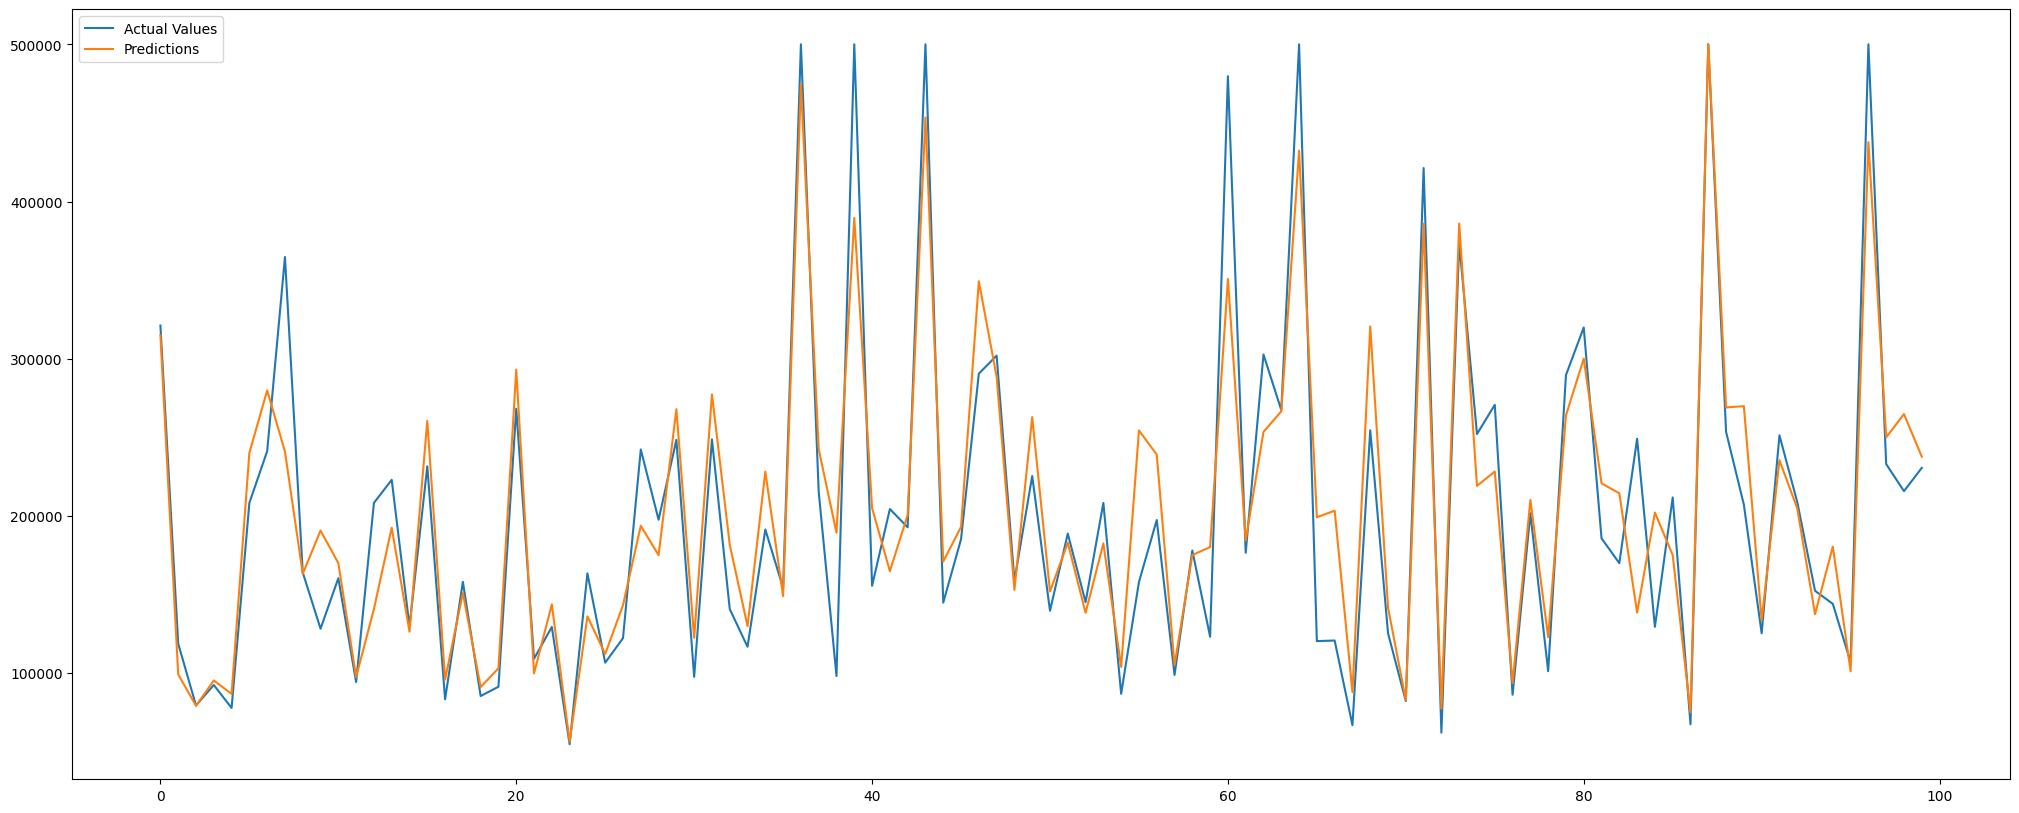

In [26]:
# plot final predictions vs actual values using line chart
plt.figure(figsize=(25, 10))
plt.plot(y_test.values[ : 100], label="Actual Values")
plt.plot(final_predictions[ : 100], label="Predictions")
plt.legend()

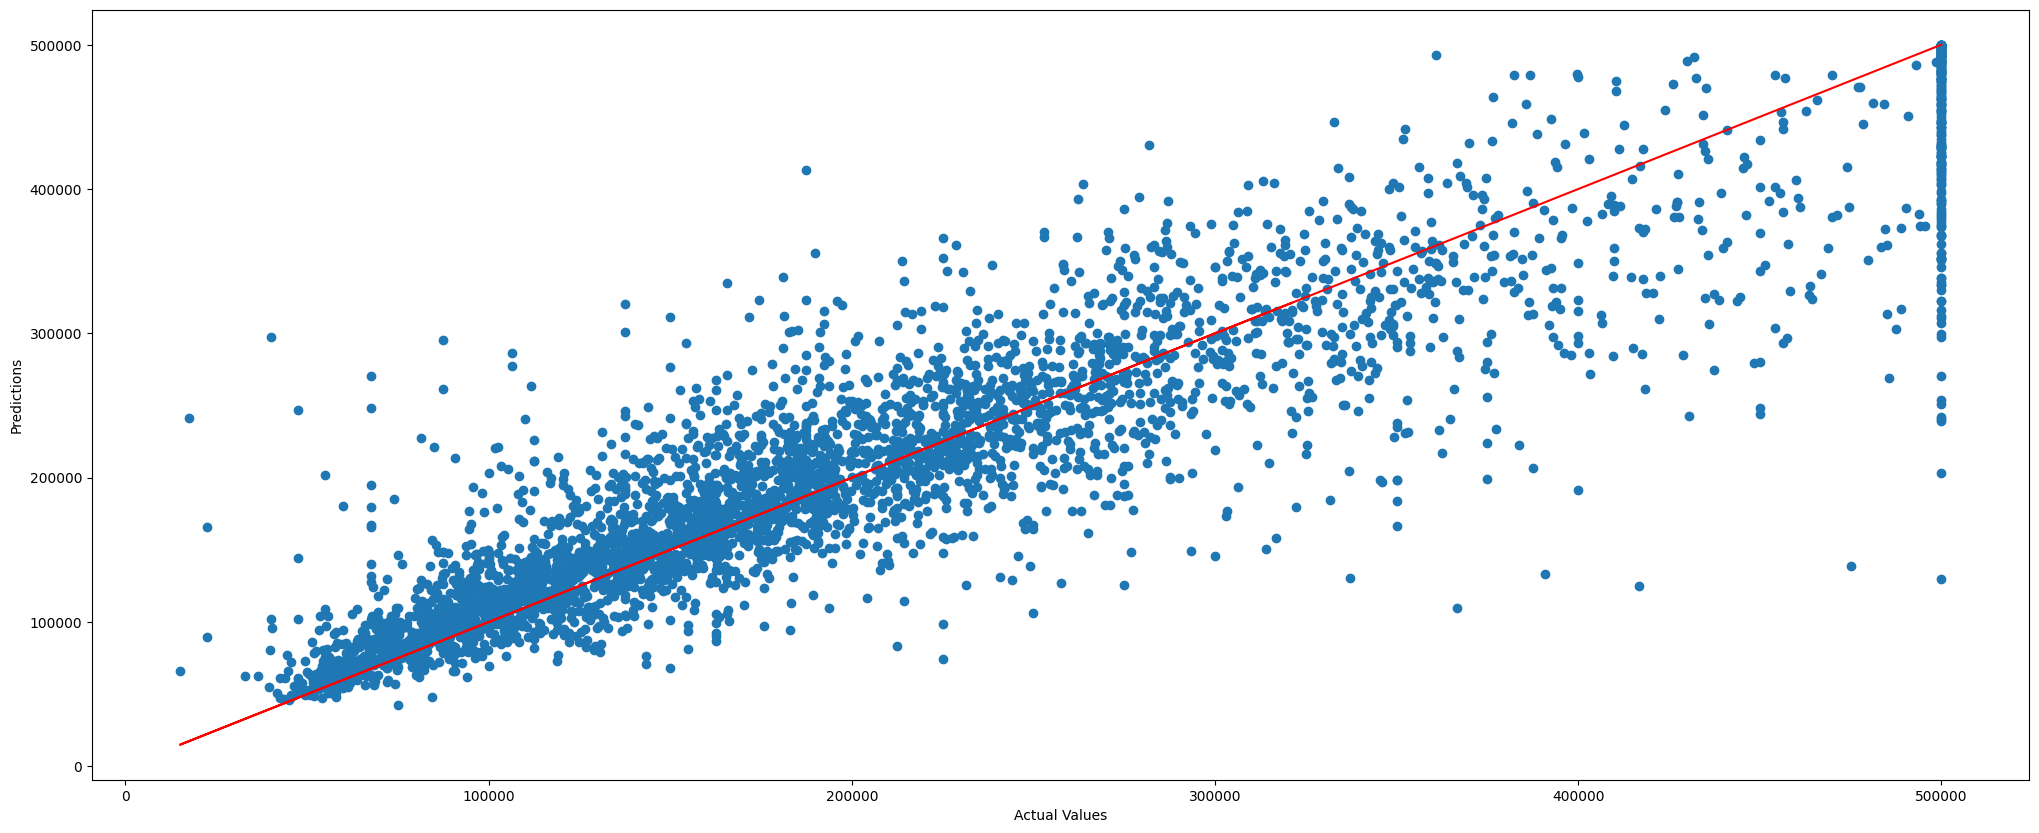

In [27]:
# plot final predictions vs actual values using scatter plot
plt.figure(figsize=(25, 10))
plt.scatter(y_test.values, final_predictions)
plt.plot(y_test.values, y_test.values, color='red')
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.show()

# **6. Launch, monitor, and maintain your system**

**Building the final pipeline with preprocessing and prediction**

In [28]:
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', grid_search.best_estimator_)
])

final_pipeline.fit(X_train, y_train)
final_pipeline.predict(X_test)

array([291606.66666667,  96990.        ,  90550.        , ...,
       254850.        , 196786.7       , 428293.5       ])

**Save model using joblib**

In [29]:
# save the model
import joblib
joblib.dump(final_pipeline, "final_pipeline.pkl")

['final_pipeline.pkl']

**Test reload the model for prediction**

In [30]:
# load the model
loaded_model = joblib.load("final_pipeline.pkl")
loaded_model.predict(X_test)

array([291606.66666667,  96990.        ,  90550.        , ...,
       254850.        , 196786.7       , 428293.5       ])